In [2]:
import pandas as pd
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.naive_bayes import GaussianNB


#load dataset
dfTrain=pd.read_csv("C:/Dataset//train.csv")
dfTest=pd.read_csv("C:/Dataset//test.csv")

#corrplot
independent_train=dfTrain.drop(["Activity","subject"],axis=1)
corrplot = independent_train.corr().abs()
upper=corrplot.where(np.triu(np.ones(corrplot.shape),k=1).astype(np.bool))
to_drop=[column for column in upper.columns if any(upper[column]>0.70)]

In [3]:
#training dataset
colnamesTrain=list(dfTrain.columns)
colnamesX_train=colnamesTrain[:-2]
Xtrain=independent_train.drop(independent_train[to_drop],axis=1)
ytrain=dfTrain.Activity
print(Xtrain.shape)
#testing dataset
colnamesTest=list(dfTest.columns)
colnamesX_test=colnamesTest[:-2]
independent_test=dfTest.drop(["Activity","subject"],axis=1)
Xtest=independent_test.drop(independent_test[to_drop],axis=1)
ytest=dfTest.Activity
print(Xtest.shape)

(7352, 107)
(2947, 107)


Accuracy on train set: 0.8518770402611534
Accuracy on test set: 0.831353919239905
Confusion Matrix Decision Tree for train set:
 [[1405    0    0    0    0    2]
 [  33  589  654    0    0   10]
 [  18   68 1281    6    0    1]
 [   0    0    0 1105   49   72]
 [   0    0    0   18  878   90]
 [   0    0    0   21   47 1005]]
Confusion Matrix Decision Tree for test set:
 [[537   0   0   0   0   0]
 [ 14 190 285   0   0   2]
 [ 13  20 485   3   3   8]
 [  0   0   0 462  30   4]
 [  0   0   0  27 348  45]
 [  0   0   0  27  16 428]]
Report on train set:
                     precision    recall  f1-score   support

            LAYING       0.96      1.00      0.98      1407
           SITTING       0.90      0.46      0.61      1286
          STANDING       0.66      0.93      0.77      1374
           WALKING       0.96      0.90      0.93      1226
WALKING_DOWNSTAIRS       0.90      0.89      0.90       986
  WALKING_UPSTAIRS       0.85      0.94      0.89      1073

          accuracy 

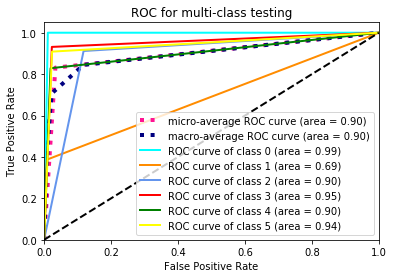

AUC for Laying vs the rest:  0.9949999491907279
AUC for Sitting vs the rest:  0.7233996540901304
AUC for Standing vs the rest:  0.9114566364880836
AUC for Walking vs the rest:  0.9469796588125706
AUC for Walking Downstairs vs the rest:  0.937693209169657
AUC for Walking Upstairs vs the rest:  0.9543778007046372


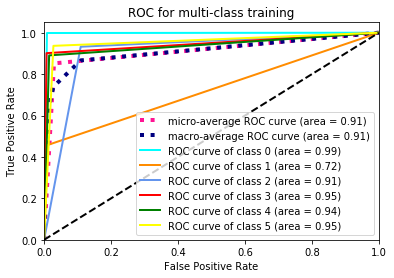

In [14]:
#create Naive Bayes model
nb=GaussianNB()

#Train decision tree classifer
nb=nb.fit(Xtrain,ytrain)

#Predict the response for train dataset
ypred_train = nb.predict(Xtrain)

#Predict the response for test dataset
ypred_test = nb.predict(Xtest)

# Model Accuracy, how often is the classifier correct?
print("Accuracy on train set:",metrics.accuracy_score(ytrain, ypred_train))
print("Accuracy on test set:",metrics.accuracy_score(ytest, ypred_test))

#Confusion matrix on train set
confusionMatrix_DT_train=confusion_matrix(ytrain,ypred_train)
print("Confusion Matrix Decision Tree for train set:\n",confusionMatrix_DT_train)

#Confusion matrix on test set
confusionMatrix_DT_test=confusion_matrix(ytest,ypred_test)
print("Confusion Matrix Decision Tree for test set:\n",confusionMatrix_DT_test)

#Classification report
print("Report on train set:\n", classification_report(ytrain, ypred_train))
print("Report on test set:\n", classification_report(ytest, ypred_test))

#ROC on test
ytest_lb = label_binarize(ytest, classes=['LAYING','SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'])
n_classes = ytest_lb.shape[1]
ypred_test_lb=label_binarize(ypred_test, classes=['LAYING','SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'])
fpr = dict()
tpr = dict()
roc_auc = dict()
ytest_probs = nb.predict_proba(Xtest)
for i in range(n_classes):
    #fpr[i], tpr[i], _ = roc_curve(ytest_lb[:, i], ytest_probs[:, i])
    fpr[i], tpr[i], _ = roc_curve(ytest_lb[:, i], ypred_test_lb[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(ytest_lb.ravel(), ypred_test_lb.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#ROC curve for a specific class
print("AUC for Laying vs the rest: ",roc_auc[0])
print("AUC for Sitting vs the rest: ",roc_auc[1])
print("AUC for Standing vs the rest: ",roc_auc[2])
print("AUC for Walking vs the rest: ",roc_auc[3])
print("AUC for Walking Downstairs vs the rest: ",roc_auc[4])
print("AUC for Walking Upstairs vs the rest: ",roc_auc[5])

#Plot ROC
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','red','green','yellow'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for multi-class testing')
plt.legend(loc="lower right")
plt.show()

#ROC on train
ytrain_lb = label_binarize(ytrain, classes=['LAYING','SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'])
n_classes_train = ytrain_lb.shape[1]
ypred_train_lb=label_binarize(ypred_train, classes=['LAYING','SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'])
fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()
ytrain_probs = nb.predict_proba(Xtrain)
for i in range(n_classes_train):
    #fpr_train[i], tpr_train[i], _ = roc_curve(ytrain_lb[:, i], ytrain_probs[:, i])
    fpr_train[i], tpr_train[i], _ = roc_curve(ytrain_lb[:, i], ypred_train_lb[:, i])
    roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

# Compute micro-average ROC curve and ROC area
fpr_train["micro"], tpr_train["micro"], _ = roc_curve(ytrain_lb.ravel(), ypred_train_lb.ravel())
roc_auc_train["micro"] = auc(fpr_train["micro"], tpr_train["micro"])

#ROC curve for a specific class
print("AUC for Laying vs the rest: ",roc_auc_train[0])
print("AUC for Sitting vs the rest: ",roc_auc_train[1])
print("AUC for Standing vs the rest: ",roc_auc_train[2])
print("AUC for Walking vs the rest: ",roc_auc_train[3])
print("AUC for Walking Downstairs vs the rest: ",roc_auc_train[4])
print("AUC for Walking Upstairs vs the rest: ",roc_auc_train[5])

#Plot ROC
# First aggregate all false positive rates
all_fpr_train = np.unique(np.concatenate([fpr_train[i] for i in range(n_classes_train)]))

# Then interpolate all ROC curves at this points
mean_tpr_train = np.zeros_like(all_fpr_train)
for i in range(n_classes_train):
    mean_tpr_train += interp(all_fpr_train, fpr_train[i], tpr_train[i])

# Finally average it and compute AUC
mean_tpr_train /= n_classes_train

fpr_train["macro"] = all_fpr_train
tpr_train["macro"] = mean_tpr_train
roc_auc_train["macro"] = auc(fpr_train["macro"], tpr_train["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr_train["micro"], tpr_train["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_train["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr_train["macro"], tpr_train["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_train["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','red','green','yellow'])
for i, color in zip(range(n_classes_train), colors):
    plt.plot(fpr_train[i], tpr_train[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc_train[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for multi-class training')
plt.legend(loc="lower right")
plt.show()